# Reco-Modell erstellen

In [1]:
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import joblib

# Daten laden

In [2]:
bgdata = pd.read_pickle("../data/bg_data20240412.pkl")

In [3]:
bgdata.head()

,id,name,yearpublished,rank,bayesaverage,average,usersrated,abstracts_rank,cgs_rank,childrensgames_rank,...,boardgameintegration,boardgamegraphicdesigner,boardgameeditor,boardgamewriter,boardgamesculptor,boardgamesolodesigner,boardgamecompilation,boardgameinsertdesigner,boardgame,boardgameissuearticle
0,224517,Brass: Birmingham,2018,1,8.41691,8.59924,44539,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,161936,Pandemic Legacy: Season 1,2015,2,8.38234,8.52972,53033,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,174430,Gloomhaven,2017,3,8.35867,8.59425,61620,NaN,NaN,NaN,...,"['Frosthaven', 'Gloomhaven: Jaws of the Lion',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,342942,Ark Nova,2021,4,8.33308,8.53772,41657,NaN,NaN,NaN,...,NaN,"['Steffen Bieker', 'Christof Tisch']","['Frank Heeren', 'Inga Keutmann', 'Bastian Win...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.24250,8.60574,23298,NaN,NaN,NaN,...,NaN,Shaun Boyke,NaN,"['Adam Baker', 'Daniel Clark (I)']",NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Doppelte Spalten "name" umbenennen:
colnames = bgdata.columns.tolist()
for y, new in zip([i for i, n in enumerate(bgdata.columns) if n == "name"], ["name", "other_names"]):
    colnames[y] = new
bgdata.columns = colnames

In [5]:
# weitere doppelte Spalten entfernen
bgdata = bgdata.loc[:,~bgdata.columns.duplicated()].copy()

In [6]:
bgdata.columns

Index(['id', 'name', 'yearpublished', 'rank', 'bayesaverage', 'average',
       'usersrated', 'abstracts_rank', 'cgs_rank', 'childrensgames_rank',
       'familygames_rank', 'partygames_rank', 'strategygames_rank',
       'thematic_rank', 'wargames_rank', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'age', 'other_names',
       'description', 'thumbnail', 'image', 'boardgameaccessory',
       'boardgamepublisher', 'cardset', 'boardgamepodcastepisode',
       'boardgamehonor', 'boardgamecategory', 'videogamebg',
       'boardgamedesigner', 'boardgameartist', 'boardgameversion',
       'boardgamefamily', 'boardgamemechanic', 'boardgamesubdomain',
       'boardgameimplementation', 'suggested_numplayers',
       'language_dependence', 'suggested_playerage', 'rpgpodcastepisode',
       'boardgameexpansion', 'boardgamedeveloper', 'boardgameintegration',
       'boardgamegraphicdesigner', 'boardgameeditor', 'boardgamewriter',
       'boardgamesculptor', 'boa

# Categories vercoden

In [7]:
bgdata["boardgamecategory"] = bgdata.boardgamecategory.apply(lambda x: re.sub("['\[\]^\s+]", '', x).split(","))

In [8]:
categories = pd.get_dummies(bgdata.boardgamecategory.apply(pd.Series), prefix = "cat")

In [9]:
categories = categories.T.groupby(categories.columns).max().T

In [10]:
# Top-Kategorien ermitteln
topcat = categories.sum().sort_values(ascending=False).index.to_list()

In [11]:
# Die Textdatei öffnen und in den Schreibmodus setzen
with open("../data/topcat.txt", 'w') as file:
    for item in topcat:
        file.write(item + ', ') 

In [12]:
# Nach Top-Kategorien sortieren
categories = categories[topcat].copy()

In [13]:
# 20 Komponenten extrahieren
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(categories)
joblib.dump(pca, "../data/pca_cat.pkl")

['../data/pca_cat.pkl']

<Axes: >

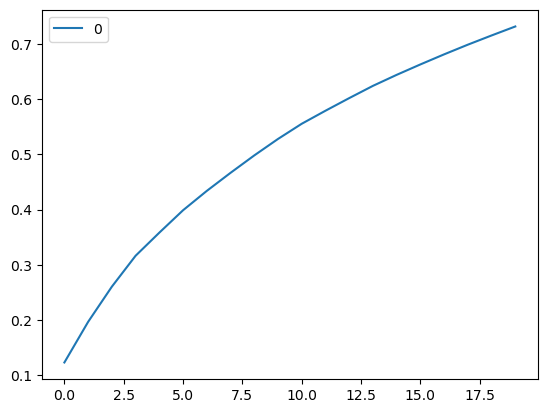

In [14]:
pd.DataFrame(pca.explained_variance_ratio_).cumsum().plot()

In [15]:
categories_pca = pd.DataFrame(pca.transform(categories), columns=["catp_" + str(x) for x in range(ncomp)])

In [16]:
bgdata = pd.concat([bgdata,categories_pca], axis=1)

# Mechanik

In [17]:
bgdata["boardgamemechanic"] = bgdata.boardgamemechanic.apply(lambda x: re.sub("['\[\]^\s+]", '', x).split(","))

In [18]:
mechanic = pd.get_dummies(bgdata.boardgamemechanic.apply(pd.Series), prefix = "mec")

In [19]:
mechanic = mechanic.T.groupby(mechanic.columns).max().T

In [20]:
# Top-Mechaniken ermitteln (später für Reco-Datensatz)
topmec = mechanic.sum().sort_values(ascending=False).index.to_list()

In [21]:
# Die Textdatei öffnen und in den Schreibmodus setzen
with open("../data/topmec.txt", 'w') as file:
    for item in topmec:
        file.write(item + ', ') 

In [22]:
# Nach Top-Mechaniken sortieren
mechanic = mechanic[topmec].copy()

In [23]:
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(mechanic)

PCA(n_components=20)

In [24]:
joblib.dump(pca, "../data/pca_mec.pkl")

['../data/pca_mec.pkl']

<Axes: >

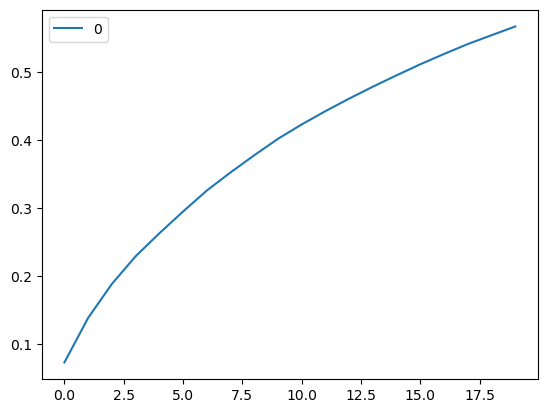

In [25]:
pd.DataFrame(pca.explained_variance_ratio_).cumsum().plot()

In [26]:
mechanic_pca = pd.DataFrame(pca.transform(mechanic), columns=["mecp_" + str(x) for x in range(ncomp)])

In [27]:
bgdata = pd.concat([bgdata,mechanic_pca], axis=1)

In [28]:
bgdata.columns

Index(['id', 'name', 'yearpublished', 'rank', 'bayesaverage', 'average',
       'usersrated', 'abstracts_rank', 'cgs_rank', 'childrensgames_rank',
       'familygames_rank', 'partygames_rank', 'strategygames_rank',
       'thematic_rank', 'wargames_rank', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'age', 'other_names',
       'description', 'thumbnail', 'image', 'boardgameaccessory',
       'boardgamepublisher', 'cardset', 'boardgamepodcastepisode',
       'boardgamehonor', 'boardgamecategory', 'videogamebg',
       'boardgamedesigner', 'boardgameartist', 'boardgameversion',
       'boardgamefamily', 'boardgamemechanic', 'boardgamesubdomain',
       'boardgameimplementation', 'suggested_numplayers',
       'language_dependence', 'suggested_playerage', 'rpgpodcastepisode',
       'boardgameexpansion', 'boardgamedeveloper', 'boardgameintegration',
       'boardgamegraphicdesigner', 'boardgameeditor', 'boardgamewriter',
       'boardgamesculptor', 'boa

# X_Train

In [29]:
allfeat = ['yearpublished', 'playingtime', 'age', 'minplayers', 'maxplayers']

In [30]:
feat = allfeat + ["catp_" + str(x) for x in range(ncomp)] + ["mecp_" + str(x) for x in range(ncomp)]

In [31]:
x_train = bgdata[feat].copy()

In [32]:
#z-Transformation
scaler = StandardScaler()
for x in allfeat:
     x_train[x] = scaler.fit_transform(x_train[x].values.reshape(-1, 1))
     joblib.dump(scaler, f"../data/scaler_{x}.pkl")

In [33]:
x_train

,yearpublished,playingtime,age,minplayers,maxplayers,catp_0,catp_1,catp_2,catp_3,catp_4,...,mecp_10,mecp_11,mecp_12,mecp_13,mecp_14,mecp_15,mecp_16,mecp_17,mecp_18,mecp_19
0,0.070905,0.198523,0.934639,0.396794,-0.145444,-0.838261,-0.588091,-0.192552,0.025221,-0.562557,...,-0.248174,-0.903544,0.589259,1.093204,0.352583,-0.606404,0.293997,-0.045777,-0.254134,0.483752
1,0.055116,-0.460804,0.452866,0.396794,-0.145444,-0.142116,0.063682,0.148947,-0.410378,0.043089,...,1.009282,-0.349837,0.031275,-0.545157,0.112957,-0.081386,0.402578,0.304836,-0.065632,-0.237580
2,0.065642,0.198523,0.934639,-1.040866,-0.145444,1.629695,-0.773512,-0.322910,0.248057,0.194133,...,-0.549885,0.744154,0.982925,-0.786259,0.153607,0.032117,1.202966,0.328467,0.612550,0.261150
3,0.086695,0.528187,0.934639,-1.040866,-0.145444,-0.680673,-0.362803,-0.230588,-0.072209,-0.366710,...,-0.286998,-0.097076,-0.037329,-0.343061,0.532346,-0.051294,-0.284268,-0.022776,-0.193163,0.089833
4,0.065642,4.154487,0.934639,1.834455,0.118520,-0.399525,-0.619436,1.240511,1.119157,0.086122,...,-0.031798,0.332129,-0.329378,0.259277,-0.241409,0.046328,0.169045,0.118251,-1.085089,0.142976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.097221,-0.131140,0.934639,-1.040866,-0.013462,-0.114478,0.157275,0.653633,0.027486,-0.179568,...,0.099418,-0.327680,-0.340473,0.011368,0.669996,-0.342519,0.019506,-0.004249,-0.171493,0.240011
496,0.060379,-0.625636,0.934639,0.396794,-0.145444,0.354019,0.710105,-0.621803,0.144666,-0.156580,...,0.330123,-0.067240,-0.320883,0.280889,-0.110249,0.099180,0.150194,-0.239745,0.113378,0.111486
497,0.097221,-0.131140,0.934639,-1.040866,-0.013462,0.102995,-0.152202,0.172720,-0.237362,0.500424,...,-0.104443,0.040413,0.119826,0.051949,0.238471,0.005678,-0.331433,0.665429,-0.024894,-0.219595
498,0.049853,-0.680580,-0.992451,0.396794,0.118520,0.298340,-0.079983,0.056080,-0.216492,-0.233646,...,-0.309769,0.132605,-0.177347,-0.090203,0.207936,0.518857,0.197350,-0.114309,-0.090921,-0.197803


In [34]:
x_train.to_pickle("../data/x_train.pkl")

# Reco-Modell

In [35]:
recos = pd.DataFrame(euclidean_distances(x_train, x_train))

In [36]:
recos.to_pickle("../data/recos.pkl")

In [37]:
recos = pd.concat([recos, bgdata["name"]], axis=1)

In [38]:
recos.sort_values(51)[["name",51]].head(50)

,name,51
51,Kanban EV,0.000000
127,Vinhos: Deluxe Edition,1.667425
260,Kanban: Driver's Edition,2.086296
438,Distilled,2.097923
361,Nusfjord,2.192649
81,Fields of Arle,2.261951
470,The Manhattan Project,2.301649
37,Viticulture Essential Edition,2.310207
310,Indonesia,2.386414
82,Hegemony: Lead Your Class to Victory,2.419003


# DataFrame für neue Abfragen erzeugen

In [39]:
recodata = pd.DataFrame(columns = allfeat + topcat + topmec)
recodata.to_pickle("../data/recodata.pkl")

In [40]:
testdata = pd.merge(bgdata[allfeat],categories[topcat], left_index=True, right_index=True)
testdata = pd.merge(testdata,mechanic[topmec], left_index=True, right_index=True)

In [41]:
testdata.to_pickle("../data/recotestdata.pkl")

In [42]:
testdata

,yearpublished,playingtime,age,minplayers,maxplayers,cat_Economic,cat_CardGame,cat_Fantasy,cat_Fighting,cat_ScienceFiction,...,mec_TurnOrder:Random,mec_Slide/Push,mec_Acting,mec_Ordering,mec_PassedActionToken,mec_PiecesasMap,mec_Ratio/CombatResultsTable,mec_RelativeMovement,mec_Singing,mec_MinimapResolution
0,2018,120,14,2,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2015,60,13,2,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2017,120,14,1,4,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2021,150,14,1,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2017,480,14,3,6,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023,90,14,1,5,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
496,2016,45,14,2,4,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
497,2023,90,14,1,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
498,2014,40,10,2,6,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [43]:
x_train

,yearpublished,playingtime,age,minplayers,maxplayers,catp_0,catp_1,catp_2,catp_3,catp_4,...,mecp_10,mecp_11,mecp_12,mecp_13,mecp_14,mecp_15,mecp_16,mecp_17,mecp_18,mecp_19
0,0.070905,0.198523,0.934639,0.396794,-0.145444,-0.838261,-0.588091,-0.192552,0.025221,-0.562557,...,-0.248174,-0.903544,0.589259,1.093204,0.352583,-0.606404,0.293997,-0.045777,-0.254134,0.483752
1,0.055116,-0.460804,0.452866,0.396794,-0.145444,-0.142116,0.063682,0.148947,-0.410378,0.043089,...,1.009282,-0.349837,0.031275,-0.545157,0.112957,-0.081386,0.402578,0.304836,-0.065632,-0.237580
2,0.065642,0.198523,0.934639,-1.040866,-0.145444,1.629695,-0.773512,-0.322910,0.248057,0.194133,...,-0.549885,0.744154,0.982925,-0.786259,0.153607,0.032117,1.202966,0.328467,0.612550,0.261150
3,0.086695,0.528187,0.934639,-1.040866,-0.145444,-0.680673,-0.362803,-0.230588,-0.072209,-0.366710,...,-0.286998,-0.097076,-0.037329,-0.343061,0.532346,-0.051294,-0.284268,-0.022776,-0.193163,0.089833
4,0.065642,4.154487,0.934639,1.834455,0.118520,-0.399525,-0.619436,1.240511,1.119157,0.086122,...,-0.031798,0.332129,-0.329378,0.259277,-0.241409,0.046328,0.169045,0.118251,-1.085089,0.142976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.097221,-0.131140,0.934639,-1.040866,-0.013462,-0.114478,0.157275,0.653633,0.027486,-0.179568,...,0.099418,-0.327680,-0.340473,0.011368,0.669996,-0.342519,0.019506,-0.004249,-0.171493,0.240011
496,0.060379,-0.625636,0.934639,0.396794,-0.145444,0.354019,0.710105,-0.621803,0.144666,-0.156580,...,0.330123,-0.067240,-0.320883,0.280889,-0.110249,0.099180,0.150194,-0.239745,0.113378,0.111486
497,0.097221,-0.131140,0.934639,-1.040866,-0.013462,0.102995,-0.152202,0.172720,-0.237362,0.500424,...,-0.104443,0.040413,0.119826,0.051949,0.238471,0.005678,-0.331433,0.665429,-0.024894,-0.219595
498,0.049853,-0.680580,-0.992451,0.396794,0.118520,0.298340,-0.079983,0.056080,-0.216492,-0.233646,...,-0.309769,0.132605,-0.177347,-0.090203,0.207936,0.518857,0.197350,-0.114309,-0.090921,-0.197803
